### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'

 ### 2 Reading Data

In [3]:
%%time

##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 341 ms, sys: 40.2 ms, total: 381 ms
Wall time: 380 ms


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location
import sqlite3
from sqlite3 import Error

def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("lead_scoring_model_experimentation.db")

2.6.0


In [7]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"

mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [8]:
# setup pycaret 
exp_lead_scoring = setup(data=dataset, target = 'app_complete_flag',  
                   fold_shuffle=True, 
                   session_id = 42,
                   normalize = True, 
                   transformation = True, 
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Lead_scoring_model_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)


,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/10/06 12:51:36 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring_model_experimentation' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [9]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7382,0.8211,0.8325,0.7022,0.7618,0.4759,0.4845,5.6220
xgboost,Extreme Gradient Boosting,0.7381,0.8209,0.8286,0.7033,0.7608,0.4756,0.4835,0.7620
et,Extra Trees Classifier,0.7366,0.8178,0.8203,0.7044,0.7579,0.4726,0.4793,4.2560
dt,Decision Tree Classifier,0.7363,0.8169,0.8199,0.7043,0.7577,0.4721,0.4787,0.6560
rf,Random Forest Classifier,0.7346,0.8168,0.8393,0.6957,0.7607,0.4685,0.4790,1.3520
lr,Logistic Regression,0.7169,0.7917,0.8013,0.6875,0.7400,0.4333,0.4395,0.3520
ridge,Ridge Classifier,0.7151,0.0000,0.8141,0.6814,0.7418,0.4296,0.4381,0.1960
lda,Linear Discriminant Analysis,0.7151,0.7904,0.8138,0.6814,0.7417,0.4295,0.4380,1.0280
nb,Naive Bayes,0.6789,0.7383,0.8537,0.6343,0.7278,0.3565,0.3804,0.2200


In [10]:
# create a model which gives the highest accuracy

lightgbm = create_model('lightgbm')

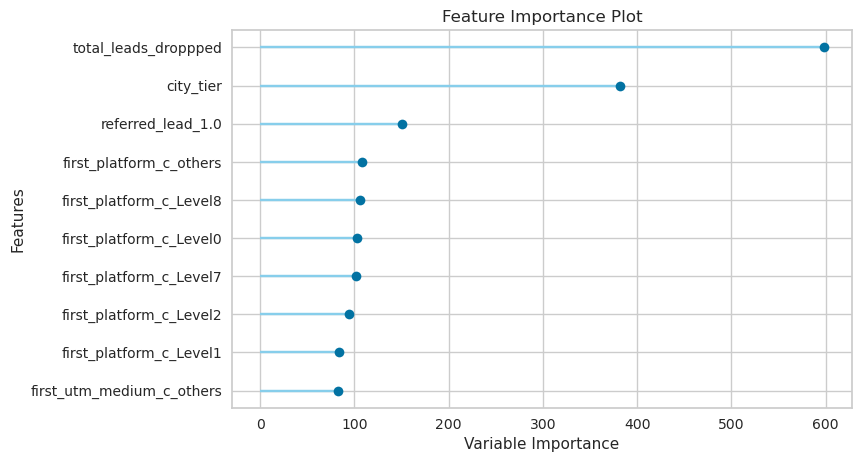

In [11]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [12]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c', 'app_complete_flag']
dataset_cols = dataset[cols]

In [13]:
from pycaret.classification import *

exp_lead_scoring = setup(data=dataset_cols, target = 'app_complete_flag',  
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],
                   fold_shuffle=True, 
                   session_id = 42,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Lead_scoring',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


2022/10/06 12:54:17 INFO mlflow.tracking.fluent: Experiment with name 'Lead_scoring' does not exist. Creating a new experiment.


In [14]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7385,0.8209,0.8313,0.7029,0.7617,0.4764,0.4847,0.6100
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8325,0.7025,0.7620,0.4764,0.4849,5.2310
et,Extra Trees Classifier,0.7364,0.8178,0.8204,0.7042,0.7579,0.4723,0.4790,4.5930
dt,Decision Tree Classifier,0.7363,0.8172,0.8202,0.7041,0.7577,0.4720,0.4787,0.6580
rf,Random Forest Classifier,0.7361,0.8183,0.8404,0.6970,0.7620,0.4715,0.4820,1.3060
lr,Logistic Regression,0.7098,0.7842,0.8220,0.6731,0.7401,0.4188,0.4296,0.1410
ridge,Ridge Classifier,0.6998,0.0000,0.7959,0.6695,0.7272,0.3989,0.4063,0.1320
lda,Linear Discriminant Analysis,0.6998,0.7733,0.7959,0.6695,0.7272,0.3989,0.4063,1.0130
nb,Naive Bayes,0.6732,0.7337,0.8569,0.6284,0.7250,0.3451,0.3709,0.1450


In [15]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

lightgbm_fs = create_model('lightgbm')

In [16]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_fs, 
                                   search_library = 'optuna',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True)

In [17]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
